In [37]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity

In [6]:
path = 'Bone Break Classification'
class_list = os.listdir(path)
print(class_list)

['Avulsion fracture', 'Comminuted fracture', 'Fracture Dislocation', 'Greenstick fracture', 'Hairline Fracture', 'Impacted fracture', 'Longitudinal fracture', 'Oblique fracture', 'Pathological fracture', 'Spiral Fracture']


In [113]:
train_images, train_labels = [], []
for (index, _class) in enumerate(class_list):
    class_path = os.path.join(path, _class)
    train_path = os.path.join(class_path, 'Train')
    for img_path in os.listdir(train_path):
        full_path = os.path.join(train_path, img_path)
        image = cv2.imread(full_path, 0)
        image = cv2.resize(image, (256,256))
        train_images.append(image)
        train_labels.append(index)

test_images, test_labels = [], []
for (index, _class) in enumerate(class_list):
    class_path = os.path.join(path, _class)
    train_path = os.path.join(class_path, 'Test')
    for img_path in os.listdir(train_path):
        full_path = os.path.join(train_path, img_path)
        image = cv2.imread(full_path, 0)
        image = cv2.resize(image, (256,256))
        test_images.append(image)
        test_labels.append(index)

In [ ]:
def preprocess_image(image):
    image = cv2.medianBlur(image, 5)
    image = cv2.equalizeHist(image)
    return image

In [ ]:
def extract_features(image, num_keypoints=100):
    sift = cv2.SIFT_create()
    akaze = cv2.AKAZE_create()

    sift_keypoints, sift_descriptors = sift.detectAndCompute(image, None)
    akaze_keypoints, akaze_descriptors = akaze.detectAndCompute(image, None)

    if sift_descriptors is None:
        sift_descriptors = np.zeros((1, 128))
    if akaze_descriptors is None:
        akaze_descriptors = np.zeros((1, 64))
    
    sift_descriptors = sift_descriptors[:num_keypoints]
    akaze_descriptors = akaze_descriptors[:num_keypoints]

    sift_descriptors = sift_descriptors.flatten()
    akaze_descriptors = akaze_descriptors.flatten()

    if len(sift_descriptors) < num_keypoints * 128:
        padding_sift = num_keypoints * 128 - len(sift_descriptors)
        sift_descriptors = np.pad(sift_descriptors, (0, padding_sift), mode='constant')

    if len(akaze_descriptors) < num_keypoints * 64:
        padding_akaze = num_keypoints * 64 - len(akaze_descriptors)
        akaze_descriptors = np.pad(akaze_descriptors, (0, padding_akaze), mode='constant')
    
    combined_keypoints = sift_keypoints + akaze_keypoints
    
    combined_descriptors = np.concatenate([sift_descriptors, akaze_descriptors])

    return combined_keypoints, combined_descriptors

In [140]:
def extract_features_without_flatten(image):
    sift = cv2.SIFT_create()
    akaze = cv2.AKAZE_create()

    sift_keypoints, sift_descriptors = sift.detectAndCompute(image, None)
    akaze_keypoints, akaze_descriptors = akaze.detectAndCompute(image, None)

    if sift_descriptors is None:
        sift_descriptors = np.zeros((1, 128))
    if akaze_descriptors is None:
        akaze_descriptors = np.zeros((1, 64))

    if akaze_descriptors.shape[1] != sift_descriptors.shape[1]:
        padded_akaze_descriptors = np.pad(akaze_descriptors, ((0, 0), (0, sift_descriptors.shape[1] - akaze_descriptors.shape[1])), mode='constant')
    else:
        padded_akaze_descriptors = akaze_descriptors

    combined_descriptors = np.vstack([sift_descriptors, padded_akaze_descriptors])
    combined_keypoints = sift_keypoints + akaze_keypoints 

    return combined_keypoints, combined_descriptors

Matching...: 0it [00:00, ?it/s]

Matching...: 989it [00:29, 33.93it/s]


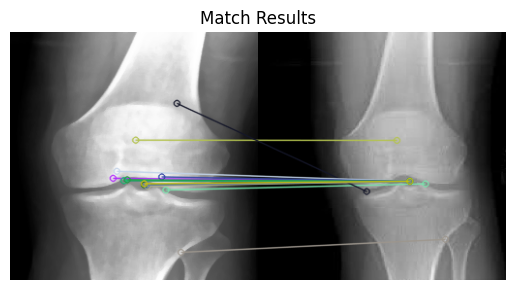

In [152]:
def find_best_match(query_image, train_images):

    query_image = preprocess_image(query_image)

    query_keypoints, query_descriptors = extract_features(query_image)

    best_similarity = -1
    best_descriptors = None
    best_keypoints = None

    for i, image in tqdm(enumerate(train_images), desc="Matching..."):
        preprocessed_image = preprocess_image(image)

        image_keypoints, image_descriptors = extract_features(preprocessed_image)
        similarity = cosine_similarity([query_descriptors], [image_descriptors])[0][0]

        if similarity > best_similarity:
            best_image = image
            best_similarity = similarity
            best_descriptors = image_descriptors

    query_keypoints, query_descriptors = extract_features_without_flatten(query_image)
    best_keypoints, best_descriptors = extract_features_without_flatten(best_image)

    # matcher = cv2.FlannBsedMatcher(dict(algorithm=1, trees=10), dict(checks=50))
    matcher = cv2.BFMatcher(cv2.NORM_L2, crossCheck=False)

    matches = matcher.knnMatch(query_descriptors, best_descriptors, k=2)

    good_matches = []
    for m, n in matches:
        if m.distance < 0.8 * n.distance:
            good_matches.append(m)

    matching_image = cv2.drawMatchesKnn(
        query_image, query_keypoints,
        best_image, best_keypoints,
        [good_matches],
        None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS
    )

    plt.imshow(cv2.cvtColor(matching_image, cv2.COLOR_BGR2RGB))
    plt.axis(False)
    plt.title("Match Results")
    plt.show()

find_best_match(test_images[11], train_images)

sesat